<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/tool_comparison/radon_dataset/keras_tuner_DNN_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q keras-tuner
%pip show keras-tuner scikit-learn

     |████████████████████████████████| 61kB 1.9MB/s 
Name: keras-tuner
Version: 1.0.1
Summary: Hypertuner for Keras
Home-page: https://github.com/keras-team/keras-tuner
Author: The Keras Tuner authors
Author-email: kerastuner@google.com
License: Apache License 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: tabulate, terminaltables, colorama, requests, scipy, scikit-learn, future, tqdm, numpy
Required-by: 
---
Name: scikit-learn
Version: 0.22.2.post1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: scipy, joblib, numpy
Required-by: yellowbrick, umap-learn, textgenrnn, sklearn, sklearn-pandas, mlxtend, lucid, lightgbm, librosa, keras-tuner, imbalanced-learn, fancyimpute


In [ ]:
import datetime, IPython, os, pprint

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer

from kerastuner import HyperModel, Hyperband, Objective
import tensorflow_datasets as tfds
from tensorflow.keras.experimental import LinearModel, WideDeepModel
from tensorflow.keras import Sequential, Input, layers, optimizers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.utils import plot_model

## データセット読み込み
- radonデータセット[https://www.tensorflow.org/datasets/catalog/radon](https://www.tensorflow.org/datasets/catalog/radon)

# データ読み込み

In [ ]:
def fetch_tf_dataset(data_name, 
                     split='train',
                     shuffle_files=True, as_supervised=True,
                     with_info=True, batch_size=None):
  '''TensorFlowデータセットからデータをフェッチ'''
  dataset, data_info = tfds.load(data_name, split=split,
                                  shuffle_files=shuffle_files,
                                  as_supervised=as_supervised,
                                  with_info=with_info,
                                  batch_size=batch_size)
  return dataset, data_info
  


data_name = 'radon' # @param{type:'string'}
x_name = 'features' # @param{type:'string'}
y_name = 'activity' # @param{type:'string'}
# インメモリでデータを読み込む
batch_size = -1

# データのフェッチ
tf_dataset, ds_info = fetch_tf_dataset(data_name=data_name,
                                     as_supervised=False,
                                     batch_size=batch_size)

display(ds_info)

Shuffling and writing examples to /root/tensorflow_datasets/radon/1.0.0.incompleteQ4JGFQ/radon-train.tfrecord


Dataset radon downloaded and prepared to /root/tensorflow_datasets/radon/1.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='radon',
    version=1.0.0,
    description='Radon is a radioactive gas that enters homes through contact
points with the ground. It is a carcinogen that is the primary cause of lung
cancer in non-smokers. Radon levels vary greatly from household to household.
This dataset contains measured radon levels in U.S homes by county and state.
The 'activity' label is the measured radon concentration in pCi/L. Important
predictors are 'floor' (the floor of the house in which the measurement was
taken), 'county' (the U.S. county in which the house is located), and 'Uppm' (a
measurement of uranium level of the soil by county).',
    homepage='http://www.stat.columbia.edu/~gelman/arm/examples/radon/',
    features=FeaturesDict({
        'activity': tf.float32,
        'features': FeaturesDict({
            'Uppm': tf.float32,
            'adjwt': tf.float32,
            'basement': tf.string,
            'cntyfips': tf.int32,
            'county': tf.string,
      

### Dataframeに変換

In [ ]:
%%time

def convert_tfds_to_df(tf_ds, x_key, y_key):
  '''tf DatasetをDataframeに変換'''
  
  # yについて{key:numpy}形式のdictに変換
  y = {}
  y[y_key] = tf_ds[y_key].numpy()

  # xについて[{key:numpy},{key:numpy},,,]形式のdictに変換
  x = {}
  for f_key, element in tf_ds[x_key].items():
    if element.dtype == 'string':
      x[f_key] = _convert_byte_np_to_string_np(bytes_np=element.numpy())
    else:
      x[f_key] = element.numpy()
  
  y_df = pd.DataFrame.from_dict(y)
  x_df = pd.DataFrame.from_dict(x)
  df = pd.concat([y_df, x_df], axis=1)

  return df


def _convert_byte_np_to_string_np(bytes_np, decode_char='utf-8'):
  '''バイナリ文字列形式のnumpy配列を文字列形式のnumpy配列に変換'''
  decode_np = np.array([])
  for b in bytes_np:
    decode_np = np.append(decode_np, b.decode(decode_char))
  decode_np = decode_np.astype('object')
  return decode_np


# tf datasetからDataframeに変換
dataset = convert_tfds_to_df(tf_dataset, x_key=x_name, y_key=y_name)


display(dataset.head())
display(dataset.shape)


# カラム名の設定
y_col = y_name
x_cols = dataset.drop(columns=y_col).columns

display('y_col:{}'.format(y_col))
display('x_cols num:{}, names:{}'.format(len(x_cols), x_cols))

,activity,Uppm,adjwt,basement,cntyfips,county,dupflag,floor,idnum,lat,lon,pcterr,region,rep,room,startdt,starttm,state,state2,stfips,stopdt,stoptm,stratum,typebldg,wave,windoor,zip,zipflag
0,1.6,2.49759,292.219543,N,3,ALLEN,0,1,1681,41.091000,-85.067001,12.7,2,3,2,11489,2230,IN,IN,18,11689,2235,2,1,92,,46835,0
1,0.5,2.66527,364.958313,N,25,YAVAPAI,0,1,1457,34.599998,-112.554001,0.0,2,5,2,22688,833,AZ,AZ,4,22888,1010,2,1,56,,86325,0
2,3.0,2.43343,626.564575,Y,17,MIDDLESEX,0,0,4224,42.485001,-71.391998,9.7,6,1,2,32288,1000,MA,MA,25,32488,1000,1,1,23,,1778,0
3,0.6,2.43343,570.611755,N,17,MIDDLESEX,0,1,4094,42.485001,-71.391998,27.6,6,3,3,32488,700,MA,MA,25,32688,1200,1,1,62,,1432,0
4,1.2,2.10811,426.798859,Y,95,JACKSON,0,0,6849,39.007999,-94.347000,23.5,1,3,4,32288,605,MO,MO,29,32488,610,2,1,91,,64134,0


(12573, 28)

'y_col:activity'

"x_cols num:27, names:Index(['Uppm', 'adjwt', 'basement', 'cntyfips', 'county', 'dupflag', 'floor',\n       'idnum', 'lat', 'lon', 'pcterr', 'region', 'rep', 'room', 'startdt',\n       'starttm', 'state', 'state2', 'stfips', 'stopdt', 'stoptm', 'stratum',\n       'typebldg', 'wave', 'windoor', 'zip', 'zipflag'],\n      dtype='object')"

CPU times: user 9.59 s, sys: 288 ms, total: 9.87 s
Wall time: 9.89 s


## 文字列をone-hotエンコード

In [ ]:
%%time

def one_hot_encode_df_val(df, target_col):
  '''文字列のカラムをone-hot-encodeしたカラムに置き換え
  INFO :　新規のカラムは先頭に挿入していく
  WARNING : target_colはdropされる
  '''
  mlb = MultiLabelBinarizer()
  one_hot_feature = mlb.fit_transform([{str(val)} for val in df[target_col].values])
  insert_columns = [target_col+'_'+str(x+1) for x in range(len(one_hot_feature[0]))]
  insert_df = pd.DataFrame(one_hot_feature, columns=insert_columns)
  df = df.drop(columns=target_col)
  df = pd.concat([insert_df, df], axis=1)
  return df

encode_cols = ['basement', 'county', 'state', 'state2', 'windoor']
for col in encode_cols:
  dataset = one_hot_encode_df_val(dataset, col)
display(dataset.head())


# カラム名の設定
y_col = y_name
x_cols = dataset.drop(columns=y_col).columns

display('y_col:{}'.format(y_col))
display('x_cols num:{}, names:{}'.format(len(x_cols), x_cols))

,windoor_1,state2_1,state2_2,state2_3,state2_4,state2_5,state2_6,state2_7,state2_8,state2_9,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,county_1,county_2,county_3,county_4,county_5,county_6,county_7,county_8,county_9,county_10,county_11,county_12,county_13,county_14,county_15,county_16,county_17,county_18,county_19,county_20,county_21,county_22,...,county_374,county_375,county_376,county_377,county_378,county_379,county_380,county_381,county_382,county_383,county_384,county_385,county_386,basement_1,basement_2,basement_3,basement_4,activity,Uppm,adjwt,cntyfips,dupflag,floor,idnum,lat,lon,pcterr,region,rep,room,startdt,starttm,stfips,stopdt,stoptm,stratum,typebldg,wave,zip,zipflag
0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.6,2.49759,292.219543,3,0,1,1681,41.091000,-85.067001,12.7,2,3,2,11489,2230,18,11689,2235,2,1,92,46835,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.5,2.66527,364.958313,25,0,1,1457,34.599998,-112.554001,0.0,2,5,2,22688,833,4,22888,1010,2,1,56,86325,0
2,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.0,2.43343,626.564575,17,0,0,4224,42.485001,-71.391998,9.7,6,1,2,32288,1000,25,32488,1000,1,1,23,1778,0
3,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.6,2.43343,570.611755,17,0,1,4094,42.485001,-71.391998,27.6,6,3,3,32488,700,25,32688,1200,1,1,62,1432,0
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.2,2.10811,426.798859,95,0,0,6849,39.007999,-94.347000,23.5,1,3,4,32288,605,29,32488,610,2,1,91,64134,0


'y_col:activity'

"x_cols num:430, names:Index(['windoor_1', 'state2_1', 'state2_2', 'state2_3', 'state2_4', 'state2_5',\n       'state2_6', 'state2_7', 'state2_8', 'state2_9',\n       ...\n       'startdt', 'starttm', 'stfips', 'stopdt', 'stoptm', 'stratum',\n       'typebldg', 'wave', 'zip', 'zipflag'],\n      dtype='object', length=430)"

CPU times: user 384 ms, sys: 48.1 ms, total: 432 ms
Wall time: 431 ms


## データ分割

In [ ]:
SEED = 7 #@param{type:'number'}

X_train, X_test, y_train, y_test = train_test_split(dataset[x_cols].values, dataset[y_col].values,
                                                    test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2, random_state=SEED)

display(X_train.shape, y_train.shape)
display(X_val.shape, y_val.shape)
display(X_test.shape, y_test.shape)

(8046, 430)

(8046,)

(2012, 430)

(2012,)

(2515, 430)

(2515,)

# HyperModelを構築
WideDeepModelを最適化
[https://www.tensorflow.org/api_docs/python/tf/keras/experimental/WideDeepModel](https://www.tensorflow.org/api_docs/python/tf/keras/experimental/WideDeepModel)

In [ ]:
class RadonHyperModel(HyperModel):

      def __init__(self, input_shape, X_adapt_norm):
          self.input_shape = input_shape
          self.norm_layer = self._setupNormalizationLayer(X=X_adapt_norm)
      

      def _setupNormalizationLayer(self, X):
          '''正規化の前処理レイヤーを初期化'''
          norm_layer = layers.experimental.preprocessing.Normalization()
          norm_layer.adapt(X)
          return norm_layer


      def build(self, hp):
          '''モデル構造と探索空間の定義'''
          model = Sequential()
          model.add(layers.Input(shape=self.input_shape))

          hp_processing_layer = hp.Boolean('is_processing_layer', default=False)
          if hp_processing_layer:
              model.add(self.norm_layer)
            
          for i in range(hp.Int('num_layers', min_value=2, max_value=5, step=1)):
              units = hp.Int('units_'+str(i), min_value=32, max_value=516, step=32)
              model.add(layers.Dense(units=units, activation='relu'))
              model.add(layers.Dropout(rate=0.3))

          model.add(layers.Dense(1))

          model.compile(
              optimizer=optimizers.Adam(hp.Choice('learning_rate', [1e-1, 1e-3, 1e-4])),
              loss='mse',
              metrics=['RootMeanSquaredError'])
          
          return model

In [ ]:
input_shape = X_train.shape[1]

hyper_model = RadonHyperModel(input_shape=input_shape,
                              X_adapt_norm=X_train)
display(hyper_model)


# Hyperbandアルゴリズム自体の試行回数(default:1)
HYPERBAND_ITERATIONS = 3 #@param{type:'number'}
# バケット内のモデルを選択する際の割合(default:3)
FACTOR = 3 #@param{type:'number'}
# モデル1つあたりの最大Epoch数
MAX_EPOCHS = 50 #@param{type:'number'}
# バケット1つあたりで試行されるパラメータ候補の数
PARAMETER_CANDIDATES = 20 # @param{type:'number'}
# 最小化する評価指標
objective = Objective('val_root_mean_squared_error', direction="min")
SEED = 7


tuner = Hyperband(hypermodel=hyper_model,
                  objective=objective,
                  hyperband_iterations=HYPERBAND_ITERATIONS,
                  factor=FACTOR,
                  max_epochs=MAX_EPOCHS,
                  seed=SEED
                  )
display(tuner)

# 早期停止コールバックの定義
es = EarlyStopping(monitor='val_loss',
                   patience=2)

class ClearTrainingOutput(Callback):
    '''Ipythonログをクリアするコールバックのクラス定義'''
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
%%time
tuner.search(x=X_train, y=y_train,
             epochs=PARAMETER_CANDIDATES,
             validation_data=(X_val, y_val),
             callbacks=[es, ClearTrainingOutput()],
             verbose=1)

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


CPU times: user 3.46 ms, sys: 1.08 ms, total: 4.54 ms
Wall time: 8.59 ms


# ベストなモデルの可視化

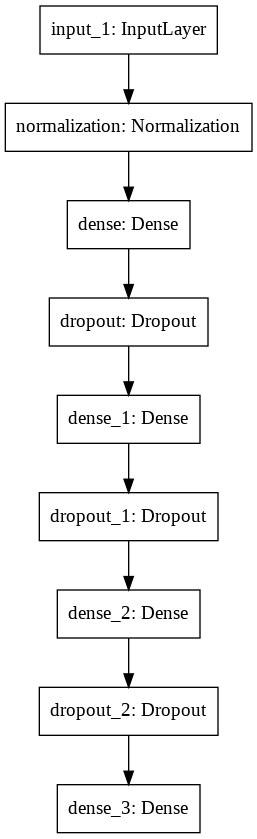

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 430)               861       
_________________________________________________________________
dense (Dense)                (None, 512)               220672    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 288)               147744    
_________________________________________________________________
dropout_1 (Dropout)          (None, 288)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 224)               64736     
_________________________________________________________________
dropout_2 (Dropout)          (None, 224)               0

None

{'is_processing_layer': True,
 'learning_rate': 0.1,
 'num_layers': 3,
 'tuner/bracket': 3,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/round': 3,
 'tuner/trial_id': '516c4b0314879602549a2b0ab9dfcbcc',
 'units_0': 512,
 'units_1': 288,
 'units_2': 224,
 'units_3': 160,
 'units_4': 480}

In [ ]:
def display_best_hp(tuner):
    '''ベストなハイパーパラメータを表示'''
    best_hp = tuner.get_best_hyperparameters()[0]
    display(best_hp.get_config()['values'])


def display_best_model(tuner):
    '''ベストなモデルの構造を表示'''
    best_model = tuner.get_best_models()[0]
    display(plot_model(best_model))
    display(best_model.summary())


display_best_model(tuner)
display_best_hp(tuner)

# モデルの評価

In [ ]:
def take_best_model(tuner):
    '''ベストなモデルを取り出し'''
    best_model = tuner.get_best_models()[0]
    return best_model


model = take_best_model(tuner)

## Kerasの組み込み評価関数

In [ ]:
score = model.evaluate(x=X_test, y=y_test, batch_size=256)
display('loss : {}, metric : {}'.format(score[0], score[1]))

10/10 [==============================] - 0s 2ms/step - loss: 70.2210 - root_mean_squared_error: 8.3798


'loss : 70.22103881835938, metric : 8.379799842834473'

## sklearnの評価関数

In [ ]:
%%time
def _calc_score(y_true, y_pred, sklearn_metric):
  '''sklearnの評価指標のスコアを計算'''
  score = sklearn_metric(y_true=y_true, y_pred=y_pred)
  return score


def evaluete_sk_metrics(y_true, y_pred, sklearn_metrics):
  '''sklearnの各種、評価関数を使用'''
  result = {}
  for sk_metric in sklearn_metrics:
    result[sk_metric.__name__] = _calc_score(y_true=y_true, y_pred=y_pred, sklearn_metric=sk_metric)
  return result


SK_METRICS=[r2_score, explained_variance_score, mean_squared_error]
eval_scores = {'train': {}, 'val': {}, 'test': {}}

for key, X, y_true in zip(['train', 'val', 'test'], [X_train, X_val, X_test], [y_train, y_val, y_test]):
  y_pred = model.predict(X)
  eval_scores[key] = evaluete_sk_metrics(y_true=y_true, y_pred=y_pred, sklearn_metrics=SK_METRICS)
pprint.pprint(eval_scores)

{'test': {'explained_variance_score': 1.1920928955078125e-07,
          'mean_squared_error': 70.22104,
          'r2_score': -0.0008753720725012126},
 'train': {'explained_variance_score': 5.960464477539063e-08,
           'mean_squared_error': 93.08346,
           'r2_score': -0.00015724414696394184},
 'val': {'explained_variance_score': 0.0,
         'mean_squared_error': 73.56368,
         'r2_score': -2.7244223987921146e-07}}
CPU times: user 551 ms, sys: 47.4 ms, total: 599 ms
Wall time: 495 ms
